In [172]:
import os
import numpy as np
import pandas as pd
import random
import sklearn
import seaborn as sns
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [2]:
#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [3]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [4]:
%cd C:\Users\GIOVANNY\Documents\Maestria\OneDrive - Universidad de Los Andes\SISTEMAS DE RECOMENDACIÓN\Taller 1\DataSet\lastfm-dataset-1K

C:\Users\GIOVANNY\Documents\Maestria\OneDrive - Universidad de Los Andes\SISTEMAS DE RECOMENDACIÓN\Taller 1\DataSet\lastfm-dataset-1K


# Carga de archivos

In [5]:
# Definición de nombres de archivos

In [6]:
path_userid = "userid-profile.tsv"
path_userbehavior = "userid-timestamp-artid-artname-traid-traname.tsv"
path_test = "test.tsv"

In [7]:
# Carga de archivos en Dataset

In [8]:
df_Userid = pd.read_csv(path_userid, sep='\t', header=0)
df_Userid.columns = ['user_id', 'gender', 'age', 'country', 'registered']

In [9]:
df_Userbehavior = pd.read_csv(path_userbehavior, sep='\t', usecols=[0, 1,2,3,4,5], header=None)
df_Userbehavior.columns = ['user_id', 'timestamp', 'artid', 'artname', 'traid', 'traname']

# Datos descriptivos 

In [10]:
# Total de usuarios registrados
df_Userid['user_id'].nunique()

992

In [11]:
missing_values_table(df_Userbehavior)

,Missing Values,% of Total Values
user_id,0,0.000000
timestamp,0,0.000000
artid,600853,3.146015
artname,0,0.000000
traid,2162726,11.323847
traname,12,0.000063


In [12]:
# Cantidad total de nombres de artistas escuchados  
df_Userbehavior['artname'].nunique()

173923

In [13]:
# Cantidad total de identificación de artistas escuchados  
df_Userbehavior['artid'].nunique()

107295

NO TODOS LOS ARTISTAS TIENEN ID, los que NO corresponde a que no se encuentran en MBID (MUSIC BRAINZ IDENTIFIER)

In [14]:
df_Userbehavior.head(10)

,user_id,timestamp,artid,artname,traid,traname
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)
5,user_000001,2009-05-04T13:38:31Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,To Stanford (Live_2009_4_15)
6,user_000001,2009-05-04T13:33:28Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Improvisation (Live_2009_4_15)
7,user_000001,2009-05-04T13:23:45Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Glacier (Live_2009_4_15)
8,user_000001,2009-05-04T13:19:22Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Parolibre (Live_2009_4_15)
9,user_000001,2009-05-04T13:13:38Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Bibo No Aozora (Live_2009_4_15)


# CONSTRUCCIÓN DE RAITING

Es construida con usuarios vs nombres de artistas (estos agrupan información y pueden ser más escalables que las canciones)

In [15]:
df_User_artname = df_Userbehavior[['user_id', 'artname']]

In [121]:
# Tabla de frecuencias de usuario - artista
df_agg1 = df_Userbehavior.groupby(['artname' , 'user_id'])['user_id'].agg({'count'})
df_agg1 = df_agg1.reset_index(level=[0,1,])
df_agg1['count'].sum()

19098862

In [122]:
# Comprobación de totales de dataframe de frecuencias y dataframe original de interacciones
df_Userbehavior.shape

(19098862, 6)

In [124]:
df_agg1.sort_values('count', ascending = False).head(10)

,artname,user_id,count
400085,Kanye West,user_000008,26496
144203,Chemistry,user_000141,25609
769610,The Knife,user_000499,18597
678218,Soilwork,user_000889,15566
117555,Britney Spears,user_000084,14614
117577,Britney Spears,user_000155,14190
209054,Dir En Grey,user_000033,12005
609005,Rancid,user_000808,11369
725177,The 69 Eyes,user_000445,10856
835274,Travis,user_000791,9654


In [125]:
# Summarized de variable de frecuencia
df_agg1.describe()

,count
count,897421.000000
mean,21.281942
std,118.216548
min,1.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,26496.000000


In [330]:
lista_users = df_Userid.user_id.values

In [333]:
# Cálculo de ratings por usuario y artista
scaler = MinMaxScaler(feature_range=(1,5))
largo = range(len(lista_users))
for i in largo :
    df_tmp = df_agg1[df_agg1.user_id==lista_users[i]]
    df_tmp['rating_lineal'] = scaler.fit_transform(df_tmp[['count']])
    if i == 0:
        df_ratings = df_tmp
    else:
        df_ratings = df_ratings.append(df_tmp, ignore_index=True)



c:\users\giovanny\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\giovanny\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\giovanny\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [334]:
# Validación de completitud
print(df_agg1.shape, df_ratings.shape)

(897421, 4) (897421, 4)


In [339]:
df_ratings.sort_values('rating_lineal',ascending=False).head(50)

,artname,user_id,count,rating_lineal
226710,Enya,user_000260,1082,5.0
823133,Pj Harvey,user_000914,1781,5.0
334226,The Doors,user_000389,909,5.0
678816,Ac/Dc,user_000761,1122,5.0
130781,Arcade Fire,user_000143,6,5.0
486425,The Black Angels,user_000571,619,5.0
205591,Broken Social Scene,user_000232,372,5.0
640857,Jonathan Larson,user_000723,6,5.0
640869,Monty Python,user_000723,6,5.0
640900,The Goo Goo Dolls,user_000723,6,5.0


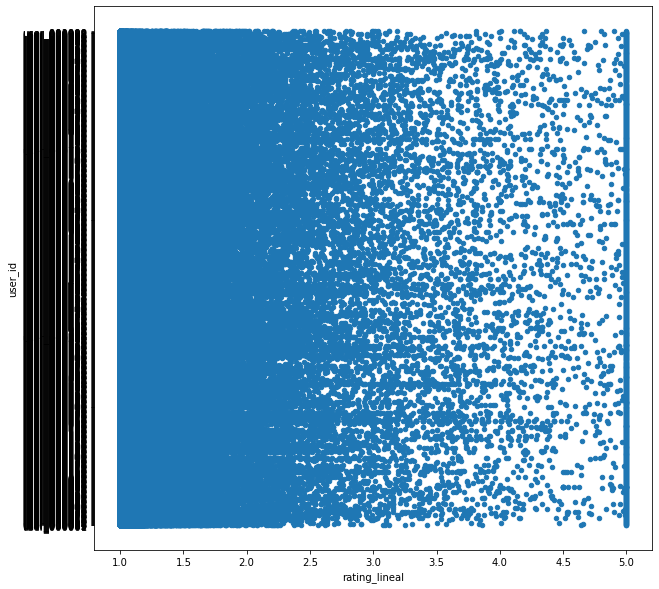

In [340]:
df_ratings.plot(x='rating_lineal',y='user_id',kind='scatter',figsize=(10,10))

In [344]:
def rating_global(x):
    if (x>=1 and x<= 2 ):
        return 1
    else:
        if (x>2 and x<=3):
            return 3
        else:
            if (x>3 and x<=4):
                return 4
            else:
                if (x>4):
                    return 5

In [345]:
df_ratings['rating_agregado'] = df_ratings.rating_lineal.apply(rating_global)

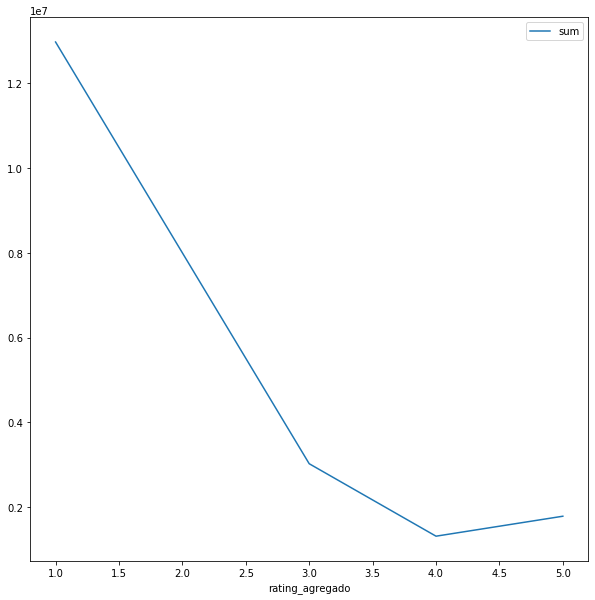

In [355]:
df_ratings_final = df_ratings.groupby(['rating_agregado'])['count'].agg({'sum'})
df_ratings_final = df_ratings_final.reset_index(level=[0])
df_ratings_final.plot.line(x='rating_agregado', y='sum', figsize=(10,10))